# Clone From GitHub

In [1]:
!git clone https://github.com/yutengkai/Louvain-Algorithm-Without-Graph-Construction.git

Cloning into 'Louvain-Algorithm-Without-Graph-Construction'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 19 (delta 3), reused 19 (delta 3), pack-reused 0
Receiving objects: 100% (19/19), 8.02 KiB | 4.01 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
import os
os.rename('Louvain-Algorithm-Without-Graph-Construction', 'louvain')

In [5]:
from louvain.src.data.data_downloading import *
from louvain.src.data.data_preprocessing import *
from louvain.src.main_algorithm import *
from louvain.src.utils import *

# Download files

In [6]:
download_ml_25m()

Download and extraction complete.


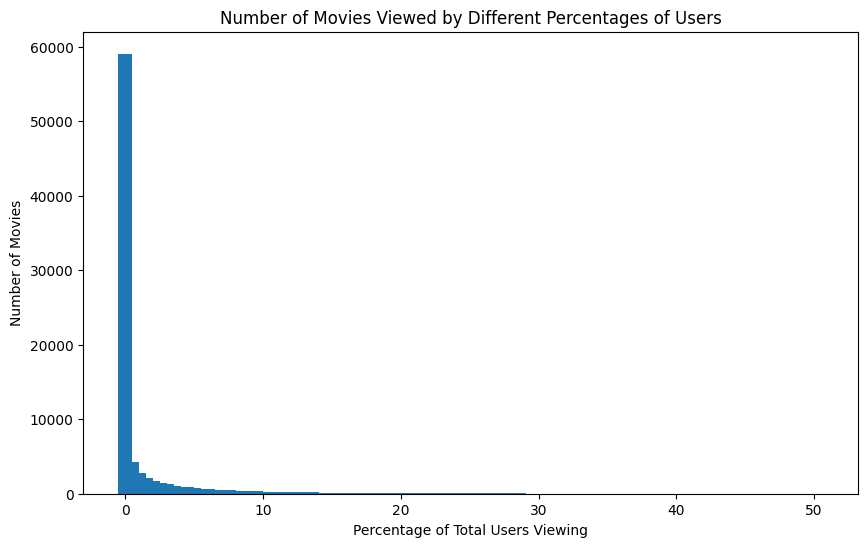

In [7]:
raw_df = pd.read_csv('ml-25m/ratings.csv')  # Load your CSV file into a DataFrame
results_df = analyze_movie_views(raw_df, step=1)

In [8]:
filtered_df = filter_movies_by_threshold(raw_df, threshold_percentage=1)
print(filtered_df.shape)
filtered_df.head()

(22523038, 4)


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [9]:
rating_matrix = df_to_matrix(filtered_df)
print(rating_matrix.shape)
rating_matrix.head()

(162539, 4216)


movieId,1,2,3,4,5,6,7,8,9,10,...,192389,192803,193065,193944,194448,194951,195159,201773,202429,204698
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Run using NetworkX

In [10]:
import torch
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

def retrieve_rows(tensor, portion_or_number, seed=None):
    """
    Randomly retrieves a specified number or portion of rows from a tensor.

    Parameters:
    tensor (torch.Tensor): The input 2D tensor.
    portion_or_number (float or int): If greater than 1, it specifies the number of rows to retrieve.
                                      If between 0 and 1, it specifies the portion (ratio) of rows to retrieve.
    seed (int, optional): A random seed for reproducibility. Defaults to None.

    Returns:
    torch.Tensor: A tensor containing the randomly selected rows.
    """
    if seed is not None:
        torch.manual_seed(seed)

    num_rows = tensor.size(0)

    if isinstance(portion_or_number, int) and portion_or_number > 1:
        num_retrieve = min(portion_or_number, num_rows)
    elif isinstance(portion_or_number, float) and 0 < portion_or_number < 1:
        num_retrieve = int(num_rows * portion_or_number)
    else:
        raise ValueError("portion_or_number must be either an integer greater than 1 or a float between 0 and 1.")

    indices = torch.randperm(num_rows)[:num_retrieve]
    return tensor[indices]

def make_positive(tensor, epsilon=1e-6):
    """
    This function takes a 2D tensor and makes all its entries positive by
    subtracting the minimum value and adding a small epsilon.

    Parameters:
    tensor (torch.Tensor): The input 2D tensor.
    epsilon (float): A small value to ensure all entries are positive.

    Returns:
    torch.Tensor: The modified tensor with all positive entries.
    """
    min_value = torch.min(tensor)
    return tensor - min_value + epsilon

def construct_graph_from_tensor(tensor):
    """
    Constructs a NetworkX graph from a 2D tensor. The nodes are indices of the tensor,
    and the edge weights are the cosine similarities of the vector representations.

    Parameters:
    tensor (torch.Tensor): The input 2D tensor.

    Returns:
    nx.Graph: The constructed NetworkX graph.
    """
    # Convert the tensor to a numpy array for cosine similarity calculation
    array = tensor.numpy()

    # Calculate cosine similarities
    cosine_sim = cosine_similarity(array)

    # Create a NetworkX graph
    G = nx.Graph()

    # Add nodes
    num_nodes = tensor.shape[0]
    G.add_nodes_from(range(num_nodes))

    # Add edges with weights based on cosine similarity
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            weight = cosine_sim[i, j]
            G.add_edge(i, j, weight=weight)

    return G

In [31]:
tensor = torch.from_numpy(rating_matrix.values)

In [32]:
tensor = retrieve_rows(tensor, 5000, seed=42)
G = construct_graph_from_tensor(tensor)

In [33]:
partition = nx.community.louvain_communities(G, seed=42)

In [34]:
len(partition)
nx.community.modularity(G, partition)

0.14662238098377753

In [35]:
def create_community_tensor(partitions):
    """
    Create a tensor of community assignments from a list of community sets.

    Parameters:
    partitions (list of sets): A list of sets, where each set contains node indices belonging to the same community.

    Returns:
    torch.Tensor: A tensor where each position contains the community number of the corresponding node.
    """
    # Determine the number of nodes
    num_nodes = sum(len(community) for community in partitions)

    # Initialize the community tensor
    community_tensor = torch.empty(num_nodes, dtype=torch.long)

    for community_number, community in enumerate(partitions):
        for node in community:
            community_tensor[node] = community_number

    return community_tensor

nx_communities = create_community_tensor(partition)

# Run using our code

In [46]:
normalized_matrix = normalize_rows_torch(tensor)
matrix = normalized_matrix.to(device='cuda')

In [47]:
partitions = louvain_partition_gpu(matrix, gamma=1.0, threshold=1e-7, max_level=-1, seed=42, print_layer_result=True)

Processing nodes: 100%|██████████| 5000/5000 [00:08<00:00, 577.10it/s]


Number of communities: 39, Delta Q: 0.07158075273036957
torch.Size([39, 4216])


Processing nodes: 100%|██████████| 39/39 [00:00<00:00, 760.77it/s]


Number of communities: 5, Delta Q: 0.0014439516235142946
torch.Size([5, 4216])


Processing nodes: 100%|██████████| 5/5 [00:00<00:00, 588.23it/s]


Number of communities: 3, Delta Q: 5.831714952364564e-05
torch.Size([3, 4216])


Processing nodes: 100%|██████████| 3/3 [00:00<00:00, 694.42it/s]

Number of communities: 3, Delta Q: 0.0
torch.Size([3, 4216])


In [38]:
final_communities = get_final_communities(partitions)

In [39]:
modularity_all_partitions(matrix, final_communities)

0.14616625756025314

In [40]:
modularity_all_partitions(matrix, nx_communities)

0.14685789868235588

In [41]:
patient_ids = range(tensor.shape[0])
partition_df = generate_patient_communities_df(patient_ids, final_communities)
partition_df2 = generate_patient_communities_df(patient_ids, nx_communities)

In [42]:
compare_communities(partition_df, partition_df2)

0.9038412502438188

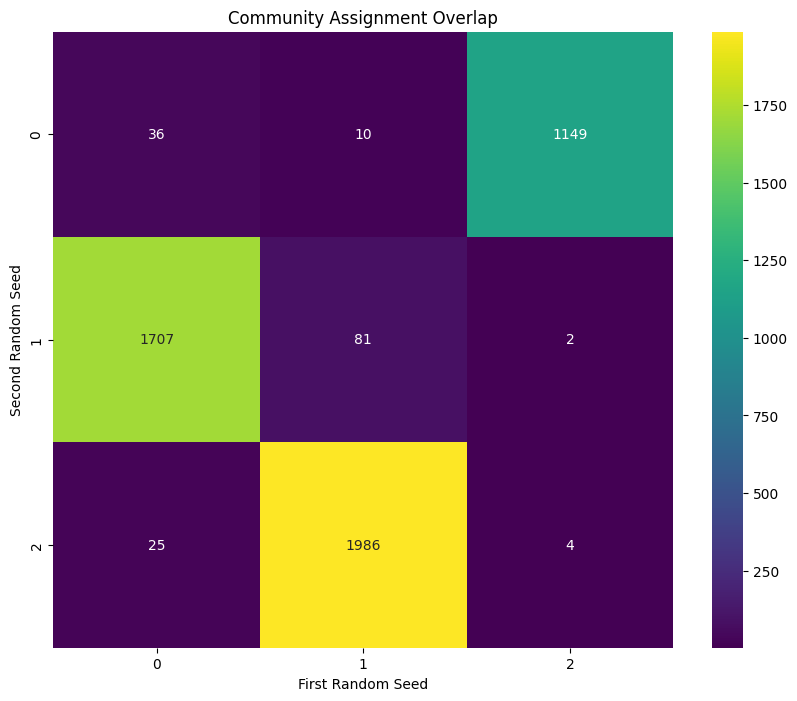

In [43]:
plot_community_overlap(partition_df, partition_df2)